In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
Rectangle1 = union_sample([RectangleDataset(device=device, coords= [(-10.0,10.0),(7,10)]), RectangleDataset(device=device, coords= [(-10.0,10.0),(-10,-7)])]) 

Rectangle2 = union_sample([RectangleDataset(device=device, coords= [(-10.0,-7),(-10,10)]), RectangleDataset(device=device, coords= [(7,10),(-10,10)])]) 

FullDataset = union_sample([Rectangle1, Rectangle2])

In [3]:
gaussian_path = GaussianConditionalProbabilityPath(p_data=FullDataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

base_model = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=5)

rec_center_trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=base_model,  num_conditions=5, p_uncond=0.1,model_type="Diffusion", rectangle_boundaries=[[(-10.0,10.0),(7,10)], [(-10.0,10.0),(-10,-7)],[(-10.0,-7),(-10,10)] ,[(7,10),(-10,10)]])

rec_center_trainer.train_loop(num_epochs=10000, device=device, lr=0.01, n = 2000)

In Epoch 0 we have a loss of 6.520360946655273
In Epoch 1000 we have a loss of 9.831822395324707
In Epoch 2000 we have a loss of 6.650326728820801
In Epoch 3000 we have a loss of 7.181931018829346
In Epoch 4000 we have a loss of 6.6830973625183105
In Epoch 5000 we have a loss of 7.7788214683532715
In Epoch 6000 we have a loss of 22.534530639648438
In Epoch 7000 we have a loss of 6.070489883422852
In Epoch 8000 we have a loss of 5.397745132446289
In Epoch 9000 we have a loss of 62.21063232421875


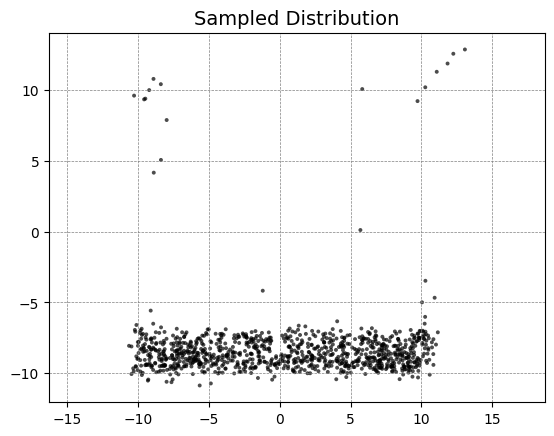

In [10]:
sde = ProductGuidanceLangevin([base_model], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales= [1.0], null_index=rec_center_trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.01, 1, 1000).view(1, -1, 1).expand(1000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(1000)


condition_index1 = 1
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 3
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index1]

final_samples = sdesampler.sample_without_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples)
plt.show()